In [118]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config





In [ ]:
###
# Algorithm to process events and try to calibrate them
###

muon_processor_config = Config({"MuonProcessor": {"RingQuery": {"quality_criteria" : [["intensity_check","np.abs(parameters.intensity_ratio - 1) < 0.2"],
                                                                                      ["ring_containment", "parameters.containment > 0.5"],
                                                                                      ["ring_completeness", "parameters.completeness > 0.5"]]}}})

checker = 0
event_container = {}
for k in range(1,21):
    filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    keks = k*1000
    for i,j in enumerate(event_iterator):
        checker += 1
        if len(j.trigger.tels_with_trigger) > 1:
            image_processor = ImageProcessor(source.subarray)
            #muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
            muon_processor = MuonProcessor(source.subarray)
            calib = CameraCalibrator(
                image_extractor_type="GlobalPeakWindowSum",
                subarray = source.subarray)
            calib(j)
            image_processor(j)
            muon_processor(j)
            for m in j.muon.tel.keys():
                if not np.isnan(j.muon.tel[m].efficiency.width):
                    event_container[keks+i] = j
        
        
            
            
        

In [ ]:
event_container

In [ ]:
k = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)

#for i,j in enumerate(event_iterator):
#    if i == 438:

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[3].camera.geometry
title="Muon Ring?"
disp = CameraDisplay(camgeom,title=title)
disp.image = event_container[2223].simulation.tel[2].true_image
#disp.image = true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
plt.show()
#break
#plt.savefig(f"/Users/vdk/IntensityCut_event{j.index.event_id}")
        

In [ ]:
#
#Timesampling
#




k = 36
event_number = 231
teln = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)


for i,j in enumerate(event_iterator):
    if i == event_number:
        print('g')
        for i in range(0,30):
            #display.image = event.r1.tel[1].waveform[:,i]
            geometry = source.subarray.tel[teln].camera.geometry
            plt.figure(figsize = (10,7))
            display = CameraDisplay(geometry)
            display.add_colorbar()
            display.image = j.r1.tel[teln].waveform[:,i]
            display.cmap = plt.cm.RdBu_r
            #plt.show()
            plt.savefig(f'/Users/vdk/GOODr1waveformProtons{str(k)+str(0)+str(event_number)}event{i}')
            
plt.close()

In [ ]:
event_number = 14406
teln = 1


fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
fig.subplots_adjust(hspace=0.2)
ax = axes[0]
camgeom = source.subarray.tel[1].camera.geometry
title=f"event{event_number}_fit{round(event_container[event_number].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[event_number].muon.tel[m].efficiency.width.to_value(),3)}"
disp = CameraDisplay(camgeom,title=title, ax = ax)
disp.image = event_container[event_number].simulation.tel[teln].true_image #.sum(axis=1)
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
bx = axes[1]
for pix_id in range(0,1855):
    bx.plot(event_container[event_number].r0.tel[teln].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
bx.set_ylabel("ADC counts")
bx.set_xlabel("Samples")
bx.set_title("Waveforms")
#plt.show()
plt.savefig(f"/Users/vdk/LSTStereoProton_event{event_number}_fit{round(event_container[event_number].muon.tel[m].efficiency.optical_efficiency,3)}_width{round(event_container[event_number].muon.tel[m].efficiency.width.to_value(),3)}.png")
#plt.savefig(f"/Users/vdk/MST_ProtonImages_NewQualityCheck/TrueImage+Waveform_mstPROTON_event{j.index.event_id}_obs{j.index.obs_id}_numer{i}")
#plt.savefig(f"/Users/vdk/TrueImage+Waveform_mstMUON_event{j.index.event_id}_obs{j.index.obs_id}")

In [ ]:
# Func to save true image together with waveform for particular event from the LSTProton stereo trigger sim
k = 2
event_number = 223
teln = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)


for i,j in enumerate(event_iterator):
    if i == event_number:
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        print("gee")
        fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
        fig.subplots_adjust(hspace=0.2)
        ax = axes[0]
        camgeom = source.subarray.tel[1].camera.geometry
        title=f"event{event_number}_fit{round(j.muon.tel[teln].efficiency.optical_efficiency,3)}_width{round(j.muon.tel[teln].efficiency.width.to_value(),3)}"
        disp = CameraDisplay(camgeom,title=title, ax = ax)
        disp.image = j.simulation.tel[teln].true_image #.sum(axis=1)
        disp.cmap = plt.cm.RdBu_r
        disp.add_colorbar()
        disp.set_limits_percent(95)
        bx = axes[1]
        for pix_id in range(0,1855):
            bx.plot(j.r0.tel[teln].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
        bx.set_ylabel("ADC counts")
        bx.set_xlabel("Samples")
        bx.set_title("Waveforms")
        plt.show()
        #plt.savefig(f"/Users/vdk/GOOD_LSTStereoProton_event{str(k)+str(0)+str(event_number)}_fit{round(j.muon.tel[teln].efficiency.optical_efficiency,3)}_width{round(j.muon.tel[teln].efficiency.width.to_value(),3)}.png")
        break

In [47]:
k = 1
event_number = 163
teln = 1
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{k}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)

for i,j in enumerate(event_iterator):
    if i == event_number:
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        event = j
        break



TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


False
872.9475948106642
True
3978.505824468706
True
1035.753188394497


/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/ctapipe/image/pixel_likelihood.py:98: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(theta + EPSILON) + (image - prediction) ** 2 / theta


74200
print <matplotlib.collections.PatchCollection object at 0x17a66f1d0>


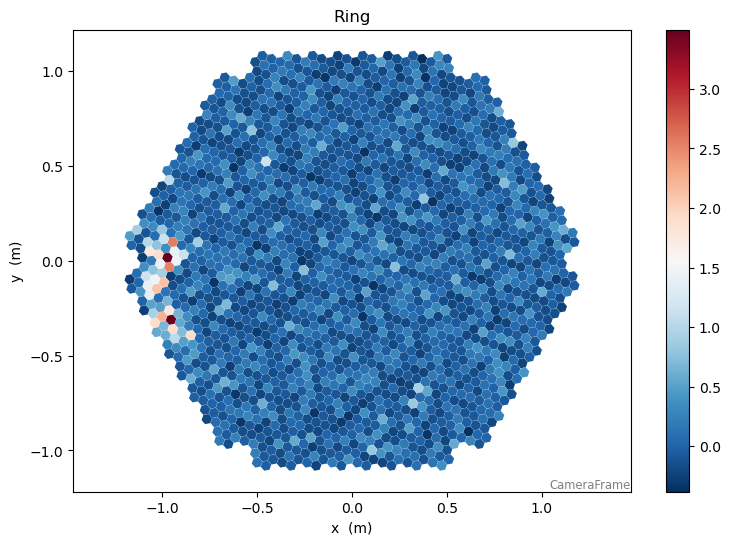

In [75]:
# check only pixels where signal is less then some value
# mean value for all pixels sum over the samples is 6200
#work_arr = event.r0.tel[1].waveform[0].copy()
#work_arr[np.sum(work_arr, axis = 1) > 10000] = 0
#teln = 2
print(np.count_nonzero(work_arr))

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Ring"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)

disp.image = event.r1.tel[teln].waveform[:,11]
#disp.image = event.dl0.tel[teln].waveform[:,11]
#disp.image = working_arr
#disp.image = event.simulation.tel[teln].true_image
#disp.image = cont_arr
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
print("print", disp.pixels)
#plt.savefig(f"/Users/vdk/IntensityCut_event{j.index.event_id}")

In [229]:
event.dl0.tel[tel_number]

ctapipe.containers.DL0CameraContainer:
                      waveform: numpy array containing data volume reduced p.e.
                                samples(n_pixels, n_samples). Note this may be a
                                masked array, if pixels or time slices are zero-
                                suppressed with default None
         selected_gain_channel: Numpy array containing the gain channel chosen
                                for each pixel. Shape: (n_pixels) with default
                                None

In [233]:
#np.sum(event.r1.tel[2].waveform, axis = 1)
event.r1.tel[tel_number].waveform.shape[-2]

1855

In [ ]:
print(min(event.r1.tel[2].waveform[:,11]))
print(max(event.r1.tel[2].waveform[:,11]))

In [ ]:
event

In [ ]:
working_arr = event.r1.tel[2].waveform[:,18].copy()
max(working_arr)

In [ ]:
working_arr = event.r1.tel[2].waveform[:,18].copy()
#mask = np.zeros(1855)
leng = 0
cont_arr = np.zeros(1855)
ring_arr = []

# If its not contamination, we assign to it value of 100
for i,j in enumerate(working_arr):
    if working_arr[i] < 5:
        cont_arr[i] = 100
        leng += 1
        working_arr[i] = 0
    else:
        cont_arr[i] = working_arr[i]

working_arr = event.r1.tel[2].waveform[:,11].copy()

for i,j in enumerate(working_arr):
    if working_arr[i] > 0.5:
        ring_arr.append(100)
    else:
        ring_arr.append(working_arr[i])

        
ring_bool_arr = [False for i in cont_arr if i is not True]
mask = np.array(working_arr, dtype=bool)       


test_mask = np.array([True for i in working_arr])

zero_mask = np.zeros(1855)

#for i,j in enumerate(working_arr):
#    if working_arr[i] > 20:
#        mask[i] = True
#    else:
#        mask[i] = False
print(leng)

#for i in mask:
#    print(i)
test_mask
min(cont_arr)

In [ ]:
#Lets create a mask to cut shower pixels from ring mask

# Index of shower pixels
shower_ind = np.zeros(1855)
# Index of ring pixels
ring_ind = np.zeros(1855)

for i,j in enumerate(cont_arr):
    if j == 100:
        shower_ind[i] = i
        
    
for i,j in enumerate(ring_arr):
    if j == 100:
        ring_ind[i] = 0
    else:
        ring_ind[i] = i

ring_final_ind = []

#Lets check if indices of ring and shower intersect
bool_arr = np.isin(ring_ind, shower_ind)

# If pixel is denoted as shower/ring then we set it to 0
for i,j in enumerate(ring_ind):
    if j in shower_ind:
        #print("j", j)
        ring_final_ind.append(0)
    else:
        ring_final_ind.append(j)

        
#for i,j in enumerate(ring_ind):
#    print("j", j)
#    if j in shower_ind:
#        ring_ind = [0]
        
        
# Now lets test this mask on the real images
working_arr = event.r1.tel[2].waveform[:,14].copy()
#for i,j in enumerate(ring_final_ind):
#    if j == 0:
#        working_arr[i] = min(event.r1.tel[2].waveform[:,11].copy())
#    else:
#        continue

#for i,j in enumerate(ring_ind):
#    if not j == 0:# and j not in shower_ind:
#        working_arr[i] = min(event.r1.tel[2].waveform[:,11].copy())
#        #working_arr[i] = 100
#    else:
#        continue

time_s = 15
working_arr = event.r1.tel[2].waveform[:,time_s].copy()
# Extracting of the ring
for i,j in enumerate(shower_ind):
    if (cont_arr[i] != 100 and ring_ind[i] == 0) or shower_ind[i] == 0 or ring_ind[i] != 0:
        #print("shower = ", cont_arr[i], ", ring = ", ring_ind[i])
        working_arr[i] = min(event.r1.tel[2].waveform[:,time_s].copy())
    

#shower_ind
#len(working_arr)
ring_ind

In [ ]:
teln = 2
print(np.count_nonzero(work_arr))

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Ring"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)

#disp.image = event.r1.tel[teln].waveform[:,11]
disp.image = working_arr
#disp.image = event.simulation.tel[teln].true_image
#disp.image = cont_arr
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
print("print", disp.pixels)
#plt.savefig(f"/Users/vdk/IntensityCut_event{j.index.event_id}")

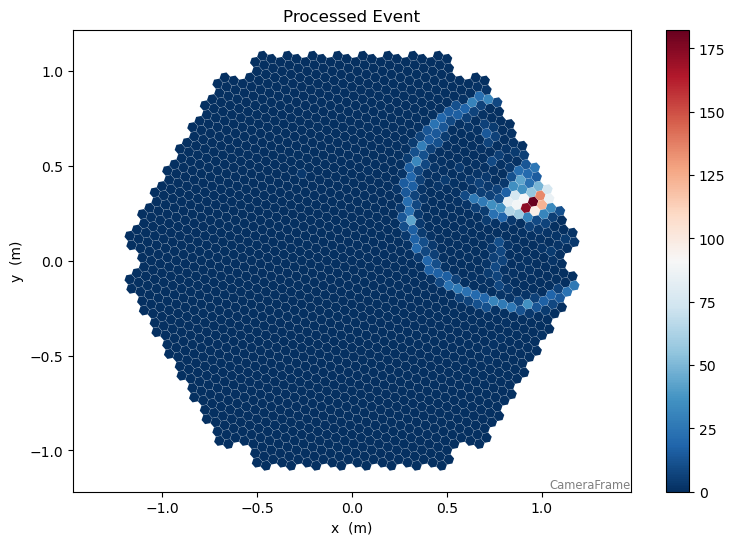

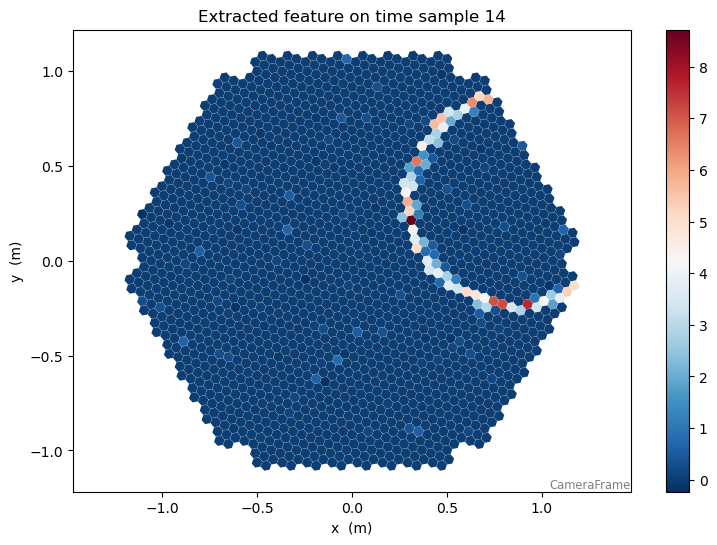

In [116]:
##
##
## Full pipeline for extracting ring and deleting shower based on time sample separation:
## 11 sample ring appears, 18 sample only shower remains
##
##
##



# Event extraction
run_number = 9
event_number = 222
tel_number = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{run_number}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)
for i,j in enumerate(event_iterator):
    if i == event_number:
        event = j
        break

# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Processed Event"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[teln].waveform[:,11]
#disp.image = working_arr
disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ProcessedEvent_event{j.index.event_id}")


# Creating waveform array for working with him, on 18 sample as usual we see only contamination
working_arr = event.r1.tel[2].waveform[:,18].copy()
leng = 0
cont_arr = np.zeros(1855)
ring_arr = []

# If its not contamination, we assign value of 100 to it
for i,j in enumerate(working_arr):
    if working_arr[i] < 4:
        cont_arr[i] = 100
        leng += 1
        working_arr[i] = 0
    else:
        cont_arr[i] = working_arr[i]

# If its not a ring we assign value of 100 to it, ring became visually distinguishable on 11 sample
working_arr = event.r1.tel[2].waveform[:,11].copy()
for i,j in enumerate(working_arr):
    if working_arr[i] > 0.35:
        ring_arr.append(100)
    else:
        ring_arr.append(working_arr[i])
    
#   
#Lets create a mask to cut shower pixels from ring mask
#

# Index of shower pixels
shower_ind = np.zeros(1855)
# Index of ring pixels
ring_ind = np.zeros(1855)

for i,j in enumerate(cont_arr):
    if j == 100:
        shower_ind[i] = i
        
    
for i,j in enumerate(ring_arr):
    if j == 100:
        ring_ind[i] = 0
    else:
        ring_ind[i] = i



time_s = 14
# time sample
image_arr = event.r1.tel[tel_number].waveform[:,time_s].copy() # array where we will preserve extracted feature
#working_arr = event.r1.tel[2].waveform[:,time_s].copy()

# Extracting of the ring
for i,j in enumerate(shower_ind):
    if (cont_arr[i] != 100 and ring_ind[i] == 0) or shower_ind[i] == 0 or ring_ind[i] != 0:
        #image_arr[i] = min(event.r1.tel[tel_number].waveform[:,time_s].copy())
        image_arr[i] = 0

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title=f"Extracted feature on time sample {time_s}"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
disp.image = image_arr
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

In [117]:
ring_mask = np.array(image_arr, dtype=bool)
np.count_nonzero(ring_mask)

177

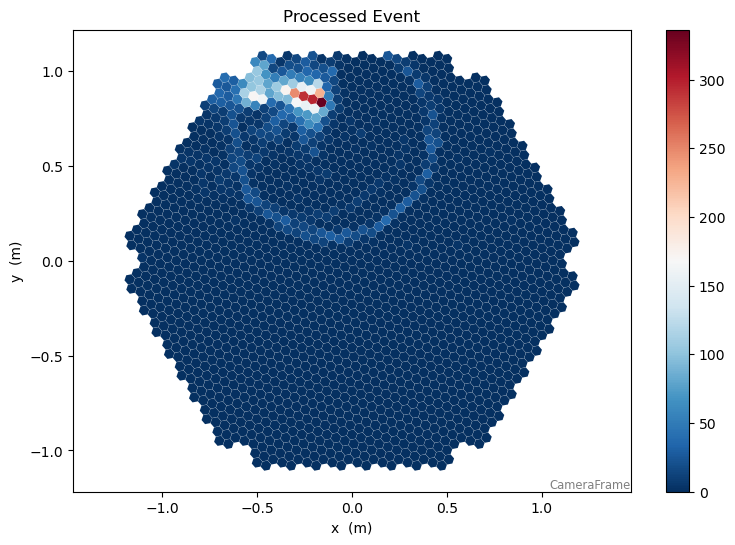

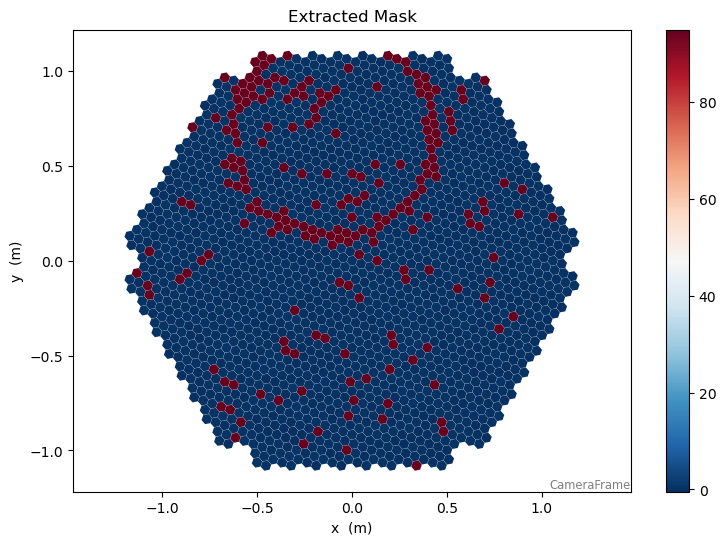

In [119]:
##
##
## Full pipeline for extracting ONLY ring
##
##
##



# Event extraction
run_number = 2
event_number = 223
tel_number = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{run_number}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)
for i,j in enumerate(event_iterator):
    if i == event_number:
        event = j
        break

# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Processed Event"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[teln].waveform[:,11]
#disp.image = working_arr
disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ProcessedEvent_event{j.index.event_id}")



ring_arr = []
# If its not a ring we assign value of 100 to it, ring became visually distinguishable on 11 sample
working_arr = event.r1.tel[tel_number].waveform[:,11].copy()
for i,j in enumerate(working_arr):
    if working_arr[i] > 0.35:
        ring_arr.append(100)
    else:
        ring_arr.append(working_arr[i])
    

# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Extracted Mask"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[teln].waveform[:,11]
disp.image = ring_arr
#disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ExtractedMask_event{run_number}_{str(0)}_{event_number}")


In [113]:
# Array for broken pixels
zero_array = np.zeros(1855)
bool_cont_image = np.array(zero_array, dtype=bool)
bool_ring_image = np.array(event.simulation.tel[2].true_image, dtype=bool)

In [ ]:
from ctapipe.image.extractor import ImageExtractor

calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
calib(event)

image_extractor = ImageExtractor.from_name("GlobalPeakWindowSum", subarray=source.subarray)
#image_extractor = ImageExtractor.from_name("GlobalPeakWindowSum", subarray=source.subarray)
image_extractor.local_weight = 0
image_extractor.window_shift = 2
image_extractor.window_width = image_extractor.window_shift.tel[2]*2+1
image_extractor

In [ ]:
#broken_pixels = np.array([False for i in event.dl0.tel[1].waveform])

#dl1_contamination = image_extractor(event.dl0.tel[2].waveform, tel_id = 2, selected_gain_channel=0, broken_pixels = bool_ring_image)
dl1_ring = image_extractor(event.dl0.tel[2].waveform, tel_id = 2, selected_gain_channel=0, broken_pixels = mask)
#dl1 = image_extractor(cont_image, tel_id = 1, selected_gain_channel=0, broken_pixels = broken_pixels)

image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray)

calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum", subarray = source.subarray)

event.dl1.tel[2] = dl1_ring
#calib(event)
image_processor(event)
muon_processor(event)

In [ ]:
print(event.muon.tel[2].efficiency)

In [ ]:
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[2].camera.geometry
title="Intensity cut"
display = CameraDisplay(camgeom,title=title)

#disp.image = event.r1.tel[2].waveform[:,:].sum(axis=1)
display.image = dl1_ring.image
#disp.image = event.simulation.tel[2].true_image
display.cmap = plt.cm.RdBu_r
display.add_colorbar()
display.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/IntensityCut_event{j.index.event_id}")

In [ ]:
array = np.array([1,2,3,4])
mask = np.array([True, False,False, True])

In [ ]:
array[mask] = 0

In [ ]:
array

In [79]:
1855/40

46.375